In [1]:
# This code works in Python 3.10.6
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from torch_geometric.datasets.dblp import DBLP
import random
import torch
from torch import optim
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, Linear, SAGEConv
import seaborn as sns
from collections import Counter
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
print(data)

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057]
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1]
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)


In [3]:
def feature_selection(df):
    col_sum = df.sum(axis=0)
    sorted_colsum = sorted(col_sum, reverse=True)
    colsum_df = pd.DataFrame(col_sum)

    sorted_colsum = sorted(col_sum, reverse=True)[:50]
    index_list = list(np.ravel(colsum_df[colsum_df[0].isin(sorted_colsum)].index))[:50]

    imp_feat = df[index_list]
    return imp_feat

In [4]:
#Original author node features
author = data['author'].x.tolist()
author_df = pd.DataFrame(author)
author_df = feature_selection(author_df)
author_df= author_df.reset_index(drop=True)
author_df.head()

,9,10,11,15,21,23,35,39,63,64,...,253,256,258,295,296,302,304,308,320,321
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#Original paper node features
paper = data['paper'].x.tolist()
paper_df = pd.DataFrame(paper)
paper_df= paper_df.reset_index(drop=True)
paper_df = feature_selection(paper_df)
paper_df.head()

,5,6,8,11,31,138,160,197,204,355,...,3404,3430,3444,3691,3703,3856,3969,4065,4158,4215
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data['author'].x = torch.tensor(author_df.values).to(dtype=torch.float32)
data['paper'].x = torch.tensor(paper_df.values).to(dtype=torch.float32)

In [7]:
data

HeteroData(
  author={
    x=[4057, 50],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057]
  },
  paper={ x=[14328, 50] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1]
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [8]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: SAGEConv((-1, -1), hidden_channels)
                for edge_type in metadata[1]
            })
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['author'])


model = HeteroGNN(data.metadata(), hidden_channels=64, out_channels=4,
                  num_layers=2)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device =  'cpu'
data, model = data.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['author'].train_mask
    loss = F.cross_entropy(out[mask], data['author'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['author'][split]
        acc = (pred[mask] == data['author'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


for epoch in range(1, 101):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 010, Loss: 0.7320, Train: 0.7750, Val: 0.6825, Test: 0.7209
Epoch: 020, Loss: 0.2991, Train: 0.8875, Val: 0.7600, Test: 0.7756
Epoch: 030, Loss: 0.1207, Train: 0.9800, Val: 0.7500, Test: 0.7605
Epoch: 040, Loss: 0.0474, Train: 0.9925, Val: 0.7400, Test: 0.7538
Epoch: 050, Loss: 0.0192, Train: 0.9975, Val: 0.7375, Test: 0.7476
Epoch: 060, Loss: 0.0100, Train: 1.0000, Val: 0.7500, Test: 0.7559
Epoch: 070, Loss: 0.0082, Train: 1.0000, Val: 0.7550, Test: 0.7565
Epoch: 080, Loss: 0.0081, Train: 1.0000, Val: 0.7525, Test: 0.7565
Epoch: 090, Loss: 0.0083, Train: 1.0000, Val: 0.7500, Test: 0.7574
Epoch: 100, Loss: 0.0081, Train: 1.0000, Val: 0.7525, Test: 0.7608


In [9]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [10]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [11]:
all_edges = {}

In [12]:
def create_dataset(nodes,edges,author_df,paper_df,term_df,conf_df,node_id,df_graph):
    
    author = np.asarray(author_df)
    paper = np.asarray(paper_df)
    term = np.asarray(term_df)
    #print('shape',author_df.columns)
    
    author = np.asarray(author_df.drop(columns=['class']))

    
    x_author = torch.tensor(author).to(dtype=torch.float32)
    y_author = torch.tensor(np.array(author_df["class"]), dtype=torch.long)
    x_paper = torch.tensor(paper).to(dtype=torch.float32)
    x_term = torch.tensor(term).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))

    author_to_paper = []
    paper_to_author = []
    paper_to_term = []
    paper_to_conf = []
    term_to_paper = []
    conf_to_paper = []
    remaining_edges = []

    class_dict = {'Paper':0, 'Author':1, 'Term':2,'Conference':3}

    for i in range(len(edges)):

        if (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Author']) and \
        (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Paper']):
                author_to_paper.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Paper']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Author']):
                paper_to_author.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Paper']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Term']):
                paper_to_term.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Paper']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Conference']):
                paper_to_conf.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Term']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Paper']):
                term_to_paper.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0]== class_dict['Conference']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Paper']):
                conf_to_paper.append((int(source[i]),int(dest[i])))

        else:
            remaining_edges.append((int(source[i]),int(dest[i])))
            
    all_edges[node_id] = [*author_to_paper,*paper_to_author,*paper_to_term,*paper_to_conf,*term_to_paper,
                          *conf_to_paper]
            
    author = list(df_graph[df_graph['class'] == 1]['nodeId'])
    author = [int(i) for i in author]
    author_nodes_mapping = remap_indices(author)
    paper = list(df_graph[df_graph['class'] == 0]['nodeId'])
    paper = [int(i) for i in paper]
    paper_nodes_mapping = remap_indices(paper)
    term = list(df_graph[df_graph['class'] == 2]['nodeId'])
    term = [int(i) for i in term]
    term_nodes_mapping = remap_indices(term)
    conf = list(df_graph[df_graph['class'] == 3]['nodeId'])
    conf = [int(i) for i in conf]
    conf_nodes_mapping = remap_indices(conf)


    node_list = {}
    for d in [author_nodes_mapping, paper_nodes_mapping, term_nodes_mapping,conf_nodes_mapping]:
            node_list.update(d)            

    #Create Hetero Data      
    small_graph = HeteroData({'author':{'x': x_author, 'y':y_author}, 'paper':{'x': x_paper},'term':{'x': x_term},
                       'conference':{'num_nodes': conf_nodes.shape[0]}})

    if author_to_paper:
        edge_index_author_paper = preprocess_edges(author_to_paper,node_list)
        small_graph['author','to','paper'].edge_index = edge_index_author_paper

    if paper_to_author:
        edge_index_paper_author = preprocess_edges(paper_to_author,node_list)
        small_graph['paper','to','author'].edge_index = edge_index_paper_author

    if paper_to_term:
        edge_index_paper_term = preprocess_edges(paper_to_term,node_list)
        small_graph['paper','to','term'].edge_index = edge_index_paper_term

    if paper_to_conf:
        edge_index_paper_conf = preprocess_edges(paper_to_conf,node_list) 
        small_graph['paper','to','conference'].edge_index = edge_index_paper_conf

    if term_to_paper:
        edge_index_term_paper = preprocess_edges(term_to_paper,node_list) 
        small_graph['term','to','paper'].edge_index = edge_index_term_paper

    if conf_to_paper:
        edge_index_conf_paper = preprocess_edges(conf_to_paper,node_list)
        small_graph['conference','to','paper'].edge_index = edge_index_conf_paper

    transform = T.Constant(node_types='conference')
    small_graph = transform(small_graph)

    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
            
    return small_graph

In [13]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        #The pred is not used for accuracy, the softmax is used
        pred = model(small_graph.x_dict, small_graph.edge_index_dict).argmax(dim=-1)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)
        
        mask = small_graph['author'].test_mask
        correct = (pred[mask] == small_graph['author'].y[mask])
               
        print(small_graph)
        print('Prediction:',pred[mask])
        print('Ground Truth:',small_graph['author'].y[mask])
        print(correct)
        print(softmax)
        
        correct_indices = [i for i, x in enumerate(correct.tolist()) if x]
        print('correct indices',correct_indices)
        
        #Taking softmax values of the nodes for which prediction is correct
        softmax_pred_list = [softmax.tolist()[i] for i in correct_indices]
        #print(softmax_pred_list)
        print('------------------------------------------------------------------')
        
        return softmax_pred_list, correct_indices

In [14]:
def apply_threshold(df):
    return df.applymap(lambda x: 0.0 if x<0.0 else 1.0)

In [15]:
def get_real_graph(size):
    real_graph = nx.Graph()
    if(size <= 5):
        real_graph = nx.read_gexf(real_graph_path+'real_G5.gexf')
    elif(size <= 10):
        real_graph = nx.read_gexf(real_graph_path+'real_G10.gexf')
    elif(size <= 15):
        real_graph = nx.read_gexf(real_graph_path+'real_G15.gexf')
    elif(size <= 20):
        real_graph = nx.read_gexf(real_graph_path+'real_G20.gexf')
    elif(size <= 25):
        real_graph = nx.read_gexf(real_graph_path+'real_G25.gexf')
    elif(size <= 30):
        real_graph = nx.read_gexf(real_graph_path+'real_G30.gexf')
    elif(size <= 35):
        real_graph = nx.read_gexf(real_graph_path+'real_G35.gexf')

    return real_graph

In [29]:
import os
import glob

softmax_dict = {}
nodefeature_dict = {}
graph_dict = {}
rootdir = '../syn_vae/dblp/'

real_graph_path = '../real_graphs/dblp/'
dir_list = []
for subdir, dirs,files in os.walk(rootdir):

    if files:
        graph_path = os.path.join(subdir, files[0])
        class_path = os.path.join(subdir, files[1])       
        feature_path = os.path.join(subdir, files[2])
        
        graph = nx.read_gexf(graph_path)
        filename = os.path.basename(graph_path)
        graph_id= filename.split('.')[0]
        #print(graph_id)
        
        nodeId_list = []
        
        for key, value in graph.nodes(data=True):
            nodeId_list.append(key)
            edges = [e for e in graph.edges]
            
        node_type_list = torch.load(class_path).detach().numpy()
        
        df_graph = pd.DataFrame()
        df_graph["nodeId"] = nodeId_list
        df_graph["class"] = node_type_list
        
        
        df_feature = pd.DataFrame(torch.load(feature_path).detach().numpy())        
        df_feature["class"] = node_type_list
        
            
        real_graph = get_real_graph(len(nodeId_list))
        
        node_label_list = []
        for n in real_graph.nodes:
            node_type = real_graph.nodes[n]["node_type"] 
            if node_type == 1:
                node_class = real_graph.nodes[n]["class"]
                node_label_list.append(node_class)
                
        
        author_node_features = apply_threshold(df_feature[df_feature['class'] == 1].drop(['class'], axis = 1))

        
        if node_label_list:
            labels = []
            unique_labels = list(set(node_label_list))

            for i in range(0,len(author_node_features)):
                labels.append(random.choice(unique_labels))
            
            author_node_features['class']= labels

            paper_node_features = apply_threshold(df_feature[df_feature['class'] == 0].drop(['class'], axis = 1))
            term_node_features = df_feature[df_feature['class'] == 2].drop(['class'], axis = 1)

            conf_nodes = df_graph[df_graph['class'] == 3].drop(['class'], axis = 1)


            small_graph_data = create_dataset(nodeId_list,edges,
                                  author_node_features,paper_node_features,
                                  term_node_features,conf_nodes,graph_id,df_graph)
    
            edge_list = all_edges[graph_id]
            graph = nx.Graph(edge_list)
            if not nx.is_empty(graph) and nx.is_connected(graph):
            
                
                if (small_graph_data['author'].x.nelement()!=0) and \
                (small_graph_data['paper','to','author']) and \
                (small_graph_data['author','to','paper']) and \
                (small_graph_data['paper','to','conference']) and \
                (small_graph_data['paper','to','term']):
                        print(graph_path)

                        softmax, correct_indices = evaluate_gnn(small_graph_data)
                        softmax_dict[graph_id] = softmax
                        nodefeature_dict[graph_id]={'author':small_graph_data['author'].x[correct_indices],
                                                         'paper':small_graph_data['paper'].x,
                                                         'term':small_graph_data['term'].x}
                        graph_dict[graph_id]=df_graph

        
        

../syn_vae/dblp/sync332712225254/sync332712225254_G16.gexf
HeteroData(
  author={
    x=[4, 50],
    y=[4],
    train_mask=[4],
    val_mask=[4],
    test_mask=[4]
  },
  paper={ x=[3, 50] },
  term={ x=[4, 50] },
  conference={
    num_nodes=5,
    x=[5, 1]
  },
  (author, to, paper)={ edge_index=[2, 1] },
  (paper, to, author)={ edge_index=[2, 1] },
  (paper, to, term)={ edge_index=[2, 1] },
  (paper, to, conference)={ edge_index=[2, 1] },
  (conference, to, paper)={ edge_index=[2, 1] }
)
Prediction: tensor([0, 2, 2, 2])
Ground Truth: tensor([0, 0, 0, 0])
tensor([ True, False, False, False])
tensor([[1.0000e+00, 2.4575e-11, 2.9820e-10, 2.4418e-06],
        [6.7476e-03, 3.5993e-03, 9.8617e-01, 3.4811e-03],
        [3.9173e-01, 3.0842e-03, 6.0402e-01, 1.1656e-03],
        [1.4200e-02, 1.3789e-03, 9.8272e-01, 1.7034e-03]])
correct indices [0]
------------------------------------------------------------------
../syn_vae/dblp/sync603656225305/sync603656225305_G22.gexf
HeteroData(
  author

../syn_vae/dblp/sync777992225232/sync777992225232_G9.gexf
HeteroData(
  author={
    x=[3, 50],
    y=[3],
    train_mask=[3],
    val_mask=[3],
    test_mask=[3]
  },
  paper={ x=[2, 50] },
  term={ x=[2, 50] },
  conference={
    num_nodes=2,
    x=[2, 1]
  },
  (author, to, paper)={ edge_index=[2, 1] },
  (paper, to, author)={ edge_index=[2, 2] },
  (paper, to, term)={ edge_index=[2, 1] },
  (paper, to, conference)={ edge_index=[2, 1] },
  (term, to, paper)={ edge_index=[2, 1] }
)
Prediction: tensor([0, 0, 2])
Ground Truth: tensor([0, 0, 0])
tensor([ True,  True, False])
tensor([[9.9994e-01, 7.4223e-08, 8.5306e-08, 6.4518e-05],
        [6.9944e-01, 1.5646e-06, 8.5114e-05, 3.0048e-01],
        [1.8089e-01, 8.7418e-02, 7.2030e-01, 1.1394e-02]])
correct indices [0, 1]
------------------------------------------------------------------
../syn_vae/dblp/sync874245225205/sync874245225205_G8.gexf
HeteroData(
  author={
    x=[2, 50],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_

In [30]:
print("No. of graphs evaluated: ",len(softmax_dict))

No. of graphs evaluated:  13


In [31]:
#Getting the list of predictions for each class
prob_class0_dict = {}
prob_class1_dict = {}
prob_class2_dict = {}
prob_class3_dict = {}
for nodeid in softmax_dict:
    

    if len(softmax_dict[nodeid]) > 0:
        list0= []
        list1= []
        list2= []
        list3= []

        for prob in softmax_dict[nodeid]:        
            list0.append(prob[0])        
            list1.append(prob[1]) 
            list2.append(prob[2]) 
            list3.append(prob[3])

     #Taking max probability of all nodes of each class in a graph
    if len(list0) != 0:
        prob_class0_dict[nodeid]=max(list0)
    if len(list1) != 0:    
        prob_class1_dict[nodeid]=max(list1)
    if len(list2) != 0:    
        prob_class2_dict[nodeid]=max(list2)
    if len(list3) != 0:    
        prob_class3_dict[nodeid]=max(list3)

In [32]:
max_pred0 = max(prob_class0_dict.values())
max_pred1 = max(prob_class1_dict.values())
max_pred2 = max(prob_class2_dict.values())
max_pred3 = max(prob_class3_dict.values())

In [33]:
class0_graphid = max(prob_class0_dict, key=prob_class0_dict.get)
class1_graphid = max(prob_class1_dict, key=prob_class1_dict.get)
class2_graphid = max(prob_class2_dict, key=prob_class2_dict.get)
class3_graphid = max(prob_class3_dict, key=prob_class3_dict.get)

In [34]:
print(class0_graphid)
print(class1_graphid)
print(class2_graphid)
print(class3_graphid)

sync854597225255_G19
sync682055225332_G27
sync493555225222_G13
sync642413225255_G20


In [35]:
def plot_graph(graphid, max_pred,nodetype,edges,graph):

    classes = []
    G = nx.Graph(edges)
    df_graph = graph_dict[graphid]
    for g in G.nodes():
        #print(g)
        #print(df_graph.loc[g]['class'])
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 0:
            classes.append(0)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 1:
            classes.append(1)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0]== 2:
            classes.append(2)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 3:
            classes.append(3)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen', 3: 'orange'}
    
    nx.set_node_attributes(G, dict(zip(G.nodes(), classes)), 'class')
    
    print('Number of nodes: ',G.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(G, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in G.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

In [36]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [37]:
def count_plot(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=15)
    plt.xticks(fontsize=15)

    plt.yticks(fontsize=15)
    plt.xlabel('feature values',fontsize=15)
    plt.ylabel('feature count',fontsize=15)

    plt.show()

Number of nodes:  9
graph id:  sync854597225255_G19
Max pred probability for class 0 is 0.9999998807907104


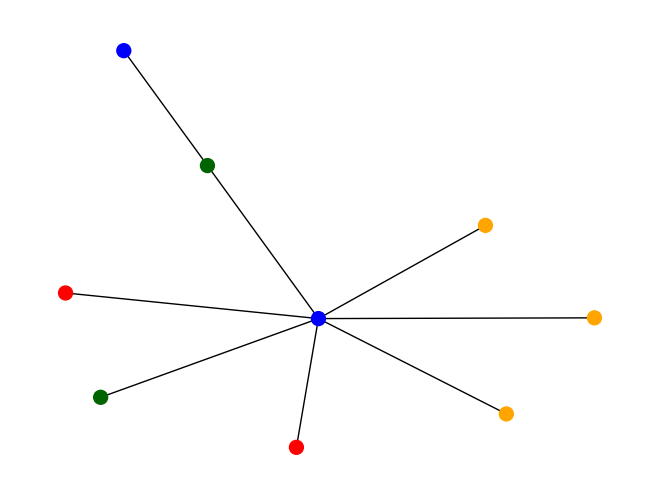

In [38]:
explanation_graph0 = plot_graph(class0_graphid, max_pred0, 0, all_edges[class0_graphid],graph_dict[class0_graphid])

In [39]:
ind= index_2d(softmax_dict[class0_graphid], max_pred0)[0]
list0= nodefeature_dict[class0_graphid]['author'].numpy()[ind]
Counter(list0)

Counter({1.0: 28, 0.0: 22})

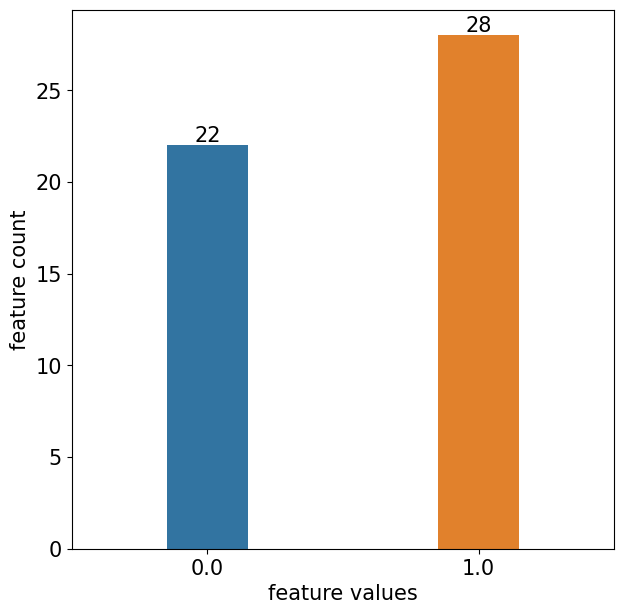

In [40]:
count_plot(list0)

Number of nodes:  15
graph id:  sync682055225332_G27
Max pred probability for class 1 is 0.9992440938949585


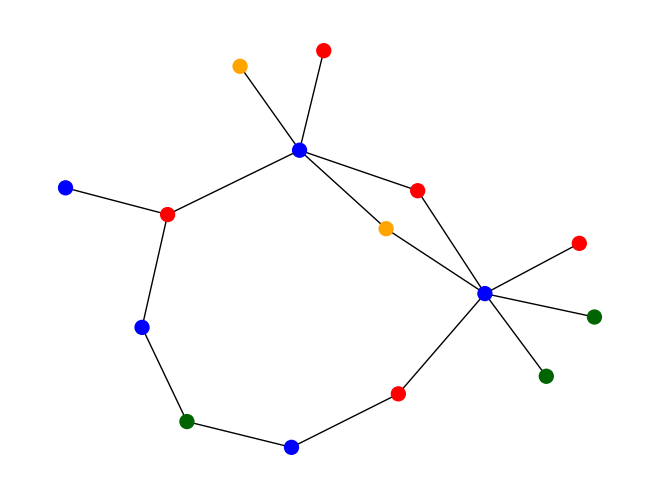

In [41]:
explanation_graph1 = plot_graph(class1_graphid, max_pred1, 1, all_edges[class1_graphid],graph_dict[class1_graphid])

In [42]:
ind= index_2d(softmax_dict[class1_graphid], max_pred1)[0]
list1= nodefeature_dict[class1_graphid]['author'].numpy()[ind]
Counter(list1)

Counter({0.0: 26, 1.0: 24})

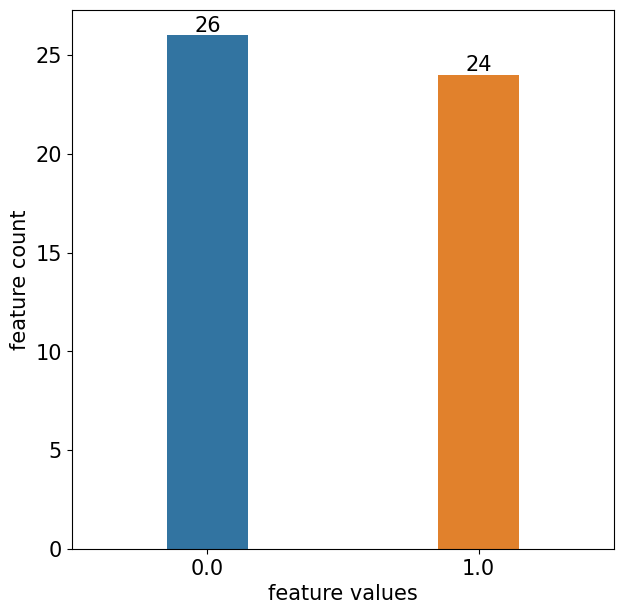

In [43]:
count_plot(list1)

Number of nodes:  9
graph id:  sync493555225222_G13
Max pred probability for class 2 is 0.8778123259544373


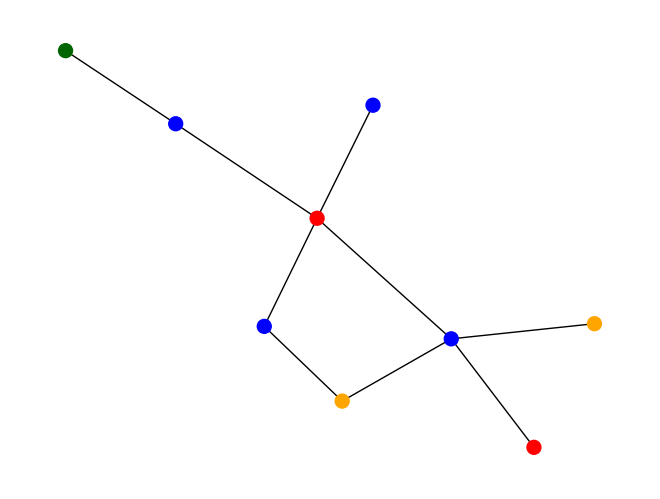

In [44]:
explanation_graph2 = plot_graph(class2_graphid, max_pred2, 2, all_edges[class2_graphid],graph_dict[class2_graphid])

In [45]:
ind= index_2d(softmax_dict[class2_graphid], max_pred2)[0]
list2= nodefeature_dict[class2_graphid]['author'].numpy()[ind]
Counter(list2)

Counter({1.0: 25, 0.0: 25})

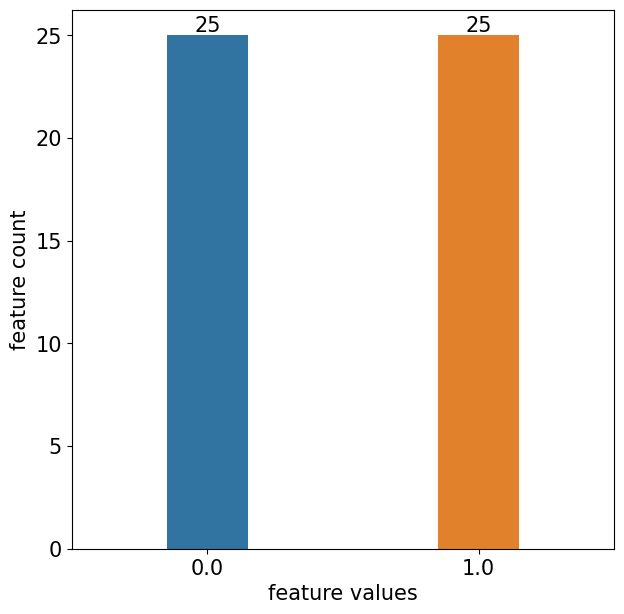

In [46]:
count_plot(list2)

Number of nodes:  9
graph id:  sync642413225255_G20
Max pred probability for class 3 is 0.9605307579040527


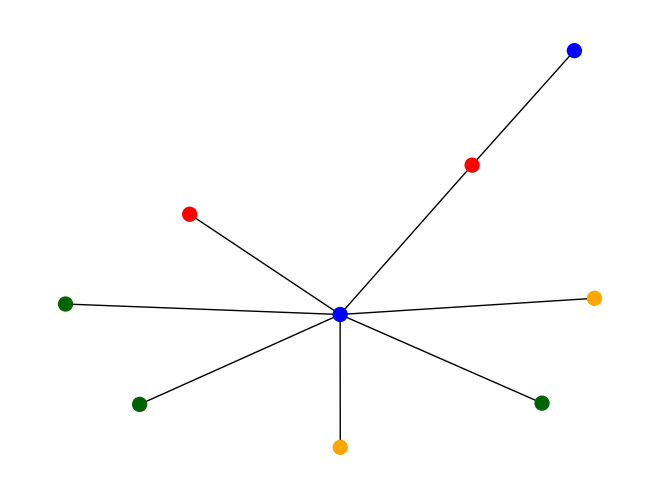

In [47]:
explanation_graph3 = plot_graph(class3_graphid, max_pred3, 3, all_edges[class3_graphid],graph_dict[class3_graphid])

In [48]:
ind= index_2d(softmax_dict[class3_graphid], max_pred3)[0]
list3= nodefeature_dict[class3_graphid]['author'].numpy()[ind]
Counter(list3)

Counter({1.0: 27, 0.0: 23})

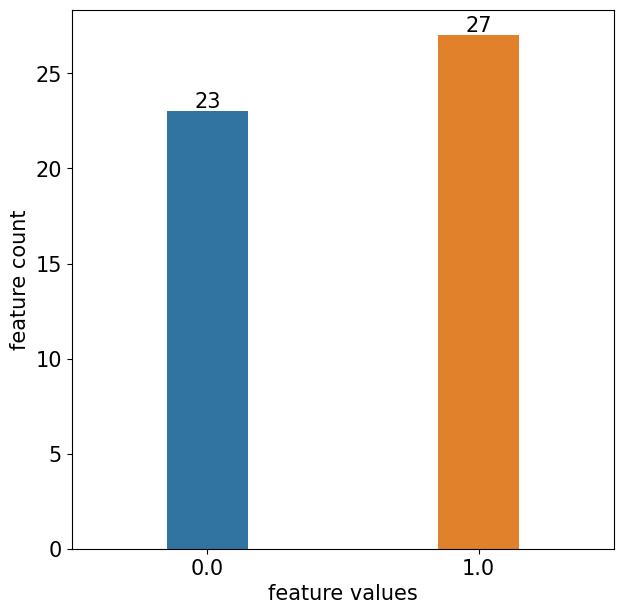

In [49]:
count_plot(list3)

In [50]:
def print_stat_cont_features(df):
    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [51]:
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Density',fontsize=15)

    plt.show() 

In [52]:
def feature_selection(df_sampled):
    col_sum = df_sampled.sum(axis=0)
    sorted_colsum = sorted(col_sum, reverse=True)

    index_list = []
    for i in sorted_colsum[:1]:
        index_list.append(list(col_sum).index(i))
        imp_feat = df_sampled[index_list].reset_index(drop=True)
        return imp_feat

In [53]:
#Term Feature Statistics
term0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['term'].numpy())
print_stat_cont_features(term0_df)

mean -0.00054703816
std dev 0.09825018


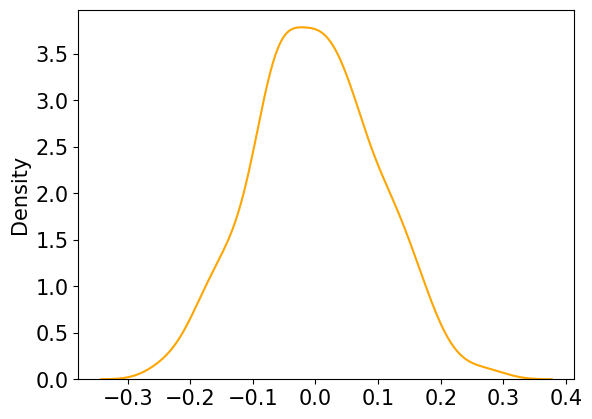

In [54]:
plot_node_feat(term0_df)

In [55]:
term1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['term'].numpy())
print_stat_cont_features(term1_df)

mean 0.0060732383
std dev 0.082443476


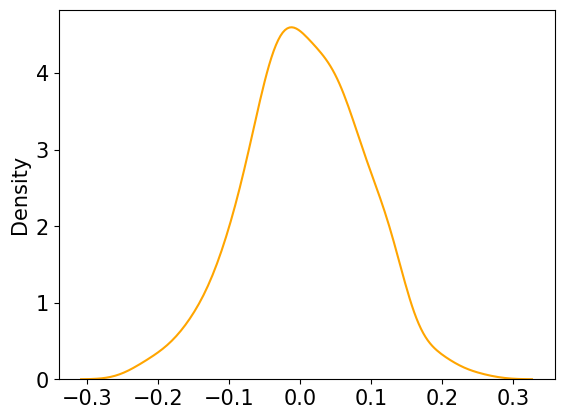

In [56]:
plot_node_feat(term1_df)

In [57]:
term2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['term'].numpy())
print_stat_cont_features(term2_df)

mean -0.0045295507
std dev 0.086382076


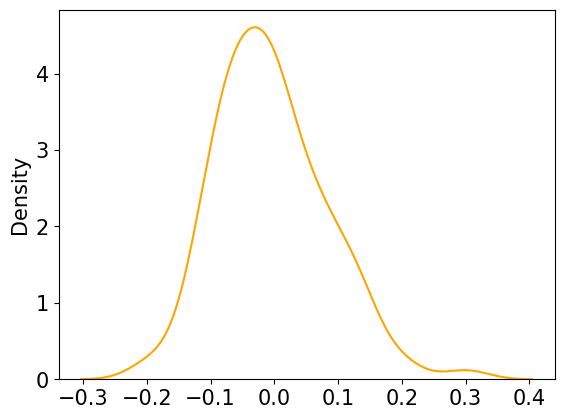

In [58]:
plot_node_feat(term2_df)

In [59]:
term3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['term'].numpy())
print_stat_cont_features(term3_df)

mean 0.001960957
std dev 0.08494058


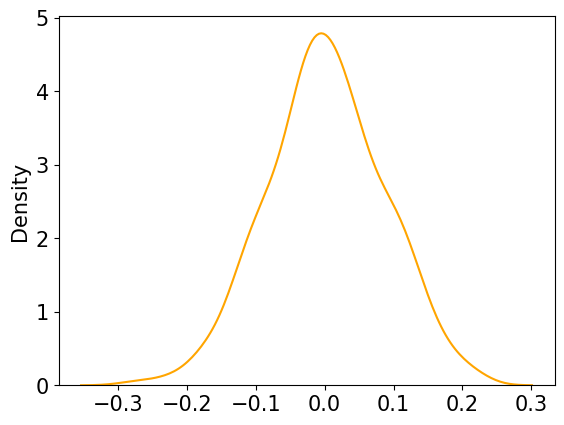

In [60]:
plot_node_feat(term3_df)

In [61]:
#Paper Features
paper0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['paper'].numpy())

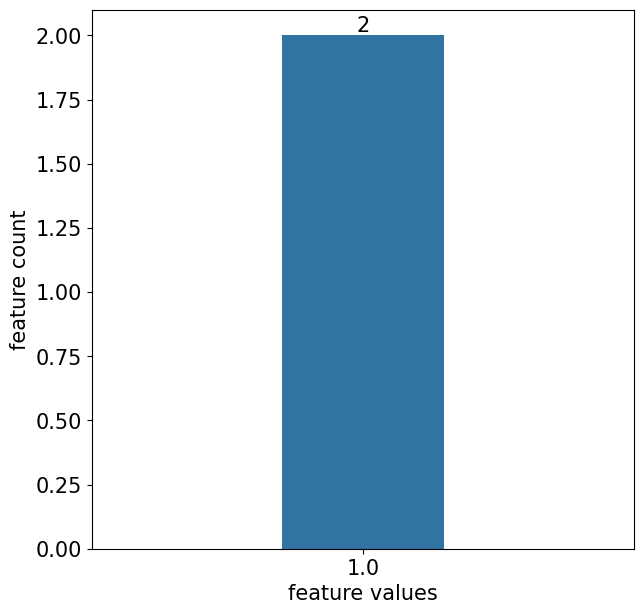

In [62]:
imp_paper_feat0=feature_selection(paper0_df)
count_plot(imp_paper_feat0.values.tolist())

In [63]:
paper1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['paper'].numpy())

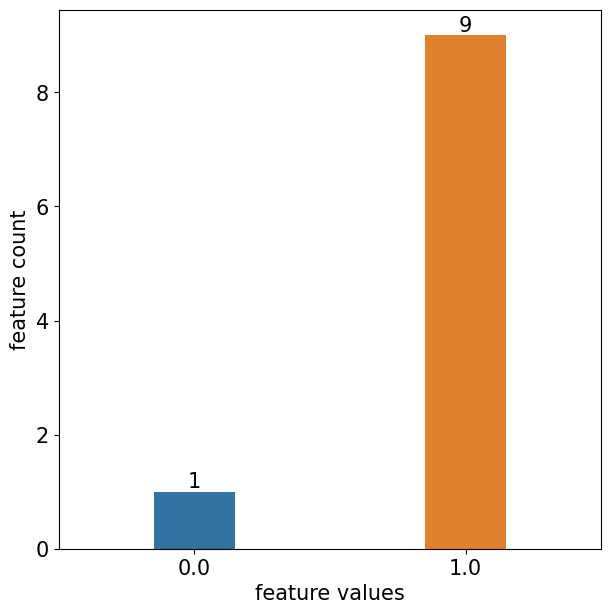

In [64]:
imp_paper_feat1=feature_selection(paper1_df)
count_plot(imp_paper_feat1.values.tolist())

In [65]:
paper2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['paper'].numpy())

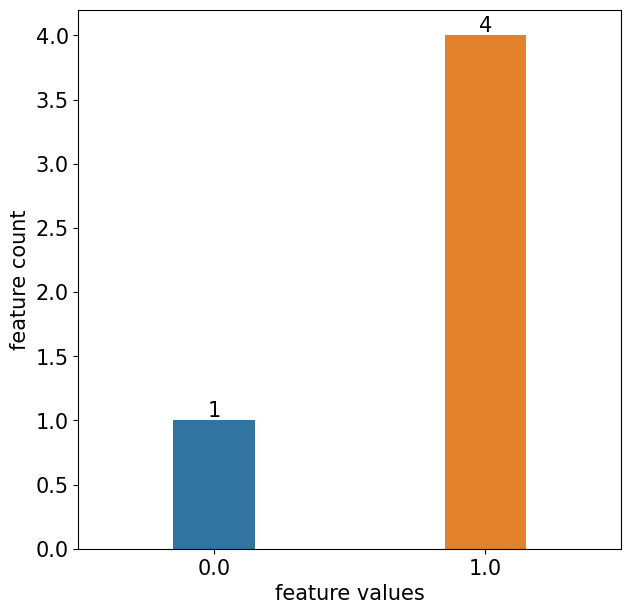

In [66]:
imp_paper_feat2=feature_selection(paper2_df)
count_plot(imp_paper_feat2.values.tolist())

In [67]:
paper3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['paper'].numpy())

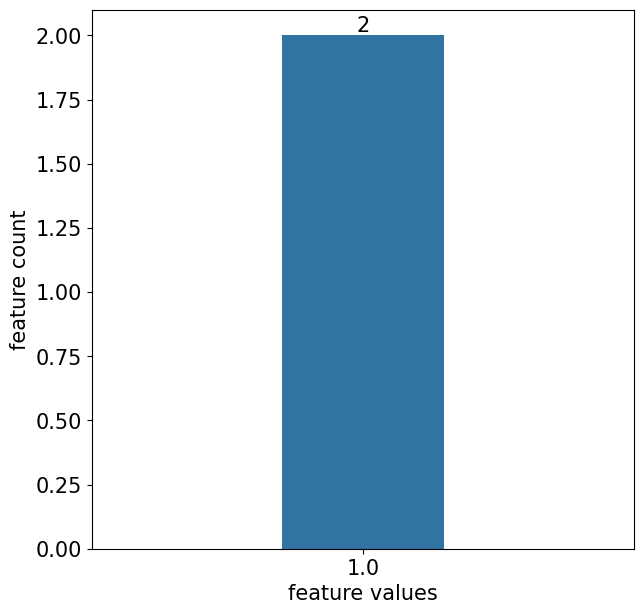

In [68]:
imp_paper_feat3=feature_selection(paper3_df)
count_plot(imp_paper_feat3.values.tolist())